In [49]:
import os
import torch
import joblib
import numpy as np
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [50]:
dataset_dir = "dataset/2D/kps_mirrored"

In [51]:
def normalize_keypoints(keypoints):
    normalized_keypoints = []

    for frame_index in range(len(keypoints)):
        keypoints_frame = keypoints[frame_index][:, :2]
        
        hip_x = keypoints_frame[11, 0] 
        hip_y = keypoints_frame[11, 1]  

        # normalize based on the hip
        keypoints_frame[:, 0] = keypoints_frame[:, 0] - hip_x
        keypoints_frame[:, 1] = keypoints_frame[:, 1] - hip_y 

        normalized_keypoints.append(keypoints_frame)

    return np.array(normalized_keypoints)

In [52]:
def load_dataset_and_find_max_length(dataset_dir):
    data = []
    labels = []
    sequence_lengths = []

    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith('.pth'): 
                video_path = os.path.join(root, file)
                
                label = os.path.basename(root) 
                print(f"Processing file: {video_path}, Label: {label}")

                tracking_results = joblib.load(video_path)
                keypoints = tracking_results[0]['keypoints']

                normalized_keypoints = normalize_keypoints(keypoints)

                data.append(normalized_keypoints)
                labels.append(label)

                sequence_lengths.append(len(normalized_keypoints))

    return data, labels, sequence_lengths

In [53]:
data, labels, sequence_lengths = load_dataset_and_find_max_length(dataset_dir)

Processing file: dataset/2D/kps_mirrored/LEG_RAISE/6_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/3_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/7_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/4_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/4.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/1.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/1_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/5.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/8_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/8.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/7.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirrored/LEG_RAISE/5_MIRRORED.pth, Label: LEG_RAISE
Processing file: dataset/2D/kps_mirro

In [54]:
unique_labels = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
labels_int = [label_map[label] for label in labels]

print("Label mapping:", label_map)
print("Converted labels:", labels_int)

Label mapping: {'ARM_RAISE': 0, 'CHAIR_RAISE_AND_STEP': 1, 'HEAD_LIFT': 2, 'LEG_RAISE': 3, 'PICK_UP': 4, 'SIT_ALL_FOURS_RISE': 5, 'SIT_UP': 6, 'SUPINE_TO_PRONE': 7}
Converted labels: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
keypoints_list = [torch.tensor(kp, dtype=torch.float32) for kp in data]
labels_tensor = torch.tensor(labels_int, dtype=torch.int64)
sequence_lengths_tensor = torch.tensor(sequence_lengths, dtype=torch.long)

In [56]:
class KeypointDataset(torch.utils.data.Dataset):
    def __init__(self, keypoints_list, labels, sequence_lengths):
        self.keypoints_list = keypoints_list
        self.labels = labels
        self.sequence_lengths = sequence_lengths

    def __len__(self):
        return len(self.keypoints_list)

    def __getitem__(self, idx):
        return self.keypoints_list[idx], self.labels[idx], self.sequence_lengths[idx]

full_dataset = KeypointDataset(keypoints_list, labels_tensor, sequence_lengths_tensor)

In [57]:
num_samples = len(full_dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"Total samples: {num_samples}")

Total samples: 128


In [58]:
def collate_fn(batch):
    keypoints, labels, seq_lengths = zip(*batch)
    keypoints = [kp.view(len(kp), -1) for kp in keypoints]  # Flatten last dimension
    keypoints_padded = pad_sequence(keypoints, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.int64)
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)
    return keypoints_padded, labels, seq_lengths

In [59]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [60]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, packed_seq):
        packed_output, (hn, cn) = self.lstm(packed_seq)
        out = self.fc(hn[-1])
        return out

In [61]:
input_size = 34  # 17 * 2 (X, Y)
hidden_size = 512
num_classes = len(unique_labels)
model = LSTMModel(input_size, hidden_size, num_classes)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_keypoints, batch_labels, batch_seq_lengths in train_loader:
            batch_keypoints = batch_keypoints.to(device)
            batch_labels = batch_labels.to(device)
            batch_seq_lengths = batch_seq_lengths.to(device)

            # Sort
            batch_seq_lengths, perm_idx = batch_seq_lengths.sort(0, descending=True)
            batch_keypoints = batch_keypoints[perm_idx]
            batch_labels = batch_labels[perm_idx]

            # Pack
            packed_input = pack_padded_sequence(batch_keypoints, batch_seq_lengths.cpu(), batch_first=True)
            outputs = model(packed_input)

            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_keypoints, batch_labels, batch_seq_lengths in val_loader:
                batch_keypoints = batch_keypoints.to(device)
                batch_labels = batch_labels.to(device)
                batch_seq_lengths = batch_seq_lengths.to(device)

                # Sort
                batch_seq_lengths, perm_idx = batch_seq_lengths.sort(0, descending=True)
                batch_keypoints = batch_keypoints[perm_idx]
                batch_labels = batch_labels[perm_idx]

                # Pack
                packed_input = pack_padded_sequence(batch_keypoints, batch_seq_lengths.cpu(), batch_first=True)
                outputs = model(packed_input)

                val_loss += criterion(outputs, batch_labels).item()

                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch [1/20], Loss: 1.8207, Val Loss: 1.5699, Accuracy: 46.15%
Epoch [2/20], Loss: 1.3411, Val Loss: 1.3295, Accuracy: 69.23%
Epoch [3/20], Loss: 1.0952, Val Loss: 1.2107, Accuracy: 69.23%
Epoch [4/20], Loss: 0.9174, Val Loss: 1.0937, Accuracy: 73.08%
Epoch [5/20], Loss: 0.8148, Val Loss: 1.0242, Accuracy: 69.23%
Epoch [6/20], Loss: 0.6999, Val Loss: 0.8631, Accuracy: 80.77%
Epoch [7/20], Loss: 0.6038, Val Loss: 0.7420, Accuracy: 88.46%
Epoch [8/20], Loss: 0.5089, Val Loss: 0.7012, Accuracy: 92.31%
Epoch [9/20], Loss: 0.4745, Val Loss: 0.6468, Accuracy: 92.31%
Epoch [10/20], Loss: 0.4080, Val Loss: 0.5935, Accuracy: 92.31%
Epoch [11/20], Loss: 0.3704, Val Loss: 0.5390, Accuracy: 92.31%
Epoch [12/20], Loss: 0.3450, Val Loss: 0.4944, Accuracy: 96.15%
Epoch [13/20], Loss: 0.3102, Val Loss: 0.4785, Accuracy: 100.00%
Epoch [14/20], Loss: 0.2648, Val Loss: 0.4466, Accuracy: 96.15%
Epoch [15/20], Loss: 0.2443, Val Loss: 0.4401, Accuracy: 100.00%
Epoch [16/20], Loss: 0.2356, Val Loss: 0.4213, 

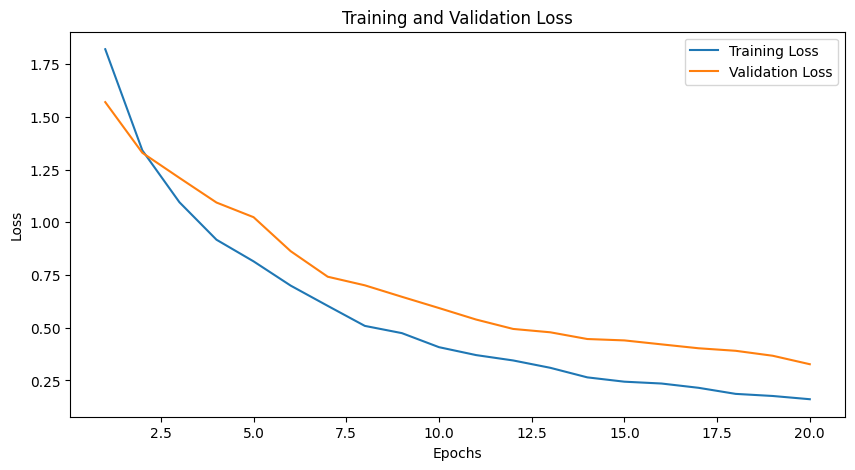

In [64]:
#train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

In [78]:
def predict(file_path):
    keypoints = joblib.load(file_path)[0]['keypoints']
    normalized_keypoints = normalize_keypoints(keypoints)

    keypoints_tensor = [torch.tensor(normalized_keypoints, dtype=torch.float32)]
    keypoints_tensor = [kp.view(len(kp), -1) for kp in keypoints_tensor]
    sequence_length = torch.tensor([len(keypoints_tensor[0])], dtype=torch.long)
    keypoints_padded = pad_sequence(keypoints_tensor, batch_first=True)

    test_model = LSTMModel(input_size, hidden_size, num_classes)
    test_model.load_state_dict(torch.load('weights/2D/512M100_Model.pth', weights_only=True))
    test_model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_model.to(device)
    keypoints_padded = keypoints_padded.to(device)
    sequence_length = sequence_length.to(device)

    sequence_length, perm_idx = sequence_length.sort(0, descending=True)
    keypoints_padded = keypoints_padded[perm_idx]

    packed_input = pack_padded_sequence(keypoints_padded, sequence_length.cpu(), batch_first=True)

    with torch.no_grad():
        output = test_model(packed_input)
        _, predicted_class = torch.max(output.data, 1)
    index_to_label = {v: k for k, v in label_map.items()}
    return index_to_label[predicted_class.item()]


FILE_TO_PREDICT = "dataset/2D/kps_unseen/STP.pth"
print(f"Prediction: {predict(FILE_TO_PREDICT)}")

Prediction: SUPINE_TO_PRONE
